In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
from sklearn.cluster import DBSCAN
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

## Väisänen et al.

In [2]:
# Read data
data_väi = pd.read_csv('/Users/maijahavusela/Desktop/gradu/data/Väisänen et al.csv',sep=',')
data_väi.head() # Erasmus+ programme

,fid,OD_ID,YEAR,COUNT,ORIGIN,DESTINATION
0,1,AL012_BG331,2020,4,AL012,BG331
1,2,AL012_BG411,2020,3,AL012,BG411
2,3,AL012_BG411,2021,6,AL012,BG411
3,4,AL012_CZ080,2021,2,AL012,CZ080
4,5,AL012_CZ080,2022,2,AL012,CZ080


In [3]:
# Choose wanted columns
data_väi = data_väi[['OD_ID','YEAR','ORIGIN','DESTINATION','COUNT']]

# Group each NUTS3 ID in the DESTINATION column and calculate the sum of the COUNT column for them
count_per_destination_väi = data_väi.groupby(["DESTINATION","YEAR"])["COUNT"].sum()

# Create a new DataFrame from the grouped result
väi_dest = pd.DataFrame({"DESTINATION_COUNT": count_per_destination_väi.values}) # How many go there
väi_dest[["NUTS3_CODE", "YEAR"]] = pd.DataFrame(count_per_destination_väi.index.tolist())

# Rename NUTS ID column
väi_dest = väi_dest.rename(
    columns={
        "DESTINATION":"NUTS3_CODE"
    }
)

# Fix order of columns
väi_dest = väi_dest[["NUTS3_CODE", "YEAR", "DESTINATION_COUNT"]]
väi_dest

,NUTS3_CODE,YEAR,DESTINATION_COUNT
0,AL012,2020,2
1,AL012,2021,1
2,AL012,2022,18
3,AL013,2014,1
4,AL013,2015,2
...,...,...,...
11959,UKN0G,2018,28
11960,UKN0G,2019,27
11961,UKN0G,2020,10
11962,UKN0G,2021,5


In [4]:
# Choose wanted columns
data_väi = data_väi[['OD_ID','YEAR','ORIGIN','DESTINATION','COUNT']]

# Group each NUTS3 ID in the DESTINATION column and calculate the sum of the COUNT column for them
count_per_origin_väi = data_väi.groupby(["ORIGIN","YEAR"])["COUNT"].sum()

# Create a new DataFrame from the grouped result
väi_orig = pd.DataFrame({"ORIGIN_COUNT": count_per_origin_väi.values}) # How many leave there
väi_orig[["NUTS3_CODE", "YEAR"]] = pd.DataFrame(count_per_origin_väi.index.tolist())

# Rename NUTS ID column
väi_orig = väi_orig.rename(
    columns={
        "ORIGIN":"NUTS3_CODE"
    }
)

# Fix order of columns
väi_orig = väi_orig[["NUTS3_CODE", "YEAR", "ORIGIN_COUNT"]]
väi_orig

,NUTS3_CODE,YEAR,ORIGIN_COUNT
0,AL012,2016,1
1,AL012,2017,2
2,AL012,2018,6
3,AL012,2019,3
4,AL012,2020,14
...,...,...,...
8634,UKN0E,2017,1
8635,UKN0F,2017,1
8636,UKN0G,2015,1
8637,UKN0G,2016,1


In [5]:
# Merge dataframes
VAISANEN = pd.merge(väi_orig, väi_dest, how="outer", on=["NUTS3_CODE","YEAR"])

# Sort by NUTS 3 codes
VAISANEN = VAISANEN.sort_values(by=["NUTS3_CODE","YEAR"])
VAISANEN

,NUTS3_CODE,YEAR,ORIGIN_COUNT,DESTINATION_COUNT
0,AL012,2016,1.0,NaN
1,AL012,2017,2.0,NaN
2,AL012,2018,6.0,NaN
3,AL012,2019,3.0,NaN
4,AL012,2020,14.0,2.0
...,...,...,...,...
12365,UKN0G,2018,NaN,28.0
12366,UKN0G,2019,NaN,27.0
12367,UKN0G,2020,NaN,10.0
12368,UKN0G,2021,NaN,5.0


In [6]:
# Create a copy of VAISANEN to keep the original unchanged
nollat = VAISANEN.copy()

# Fill NaN values with 0 in the ORIGIN_COUNT and DESTINATION_COUNT columns
nollat["ORIGIN_COUNT"].fillna(0, inplace=True)
nollat["DESTINATION_COUNT"].fillna(0, inplace=True)

# Calculate the sum of the DESTINATION_COUNT and ORIGIN_COUNT
nollat["COUNT_SUM"] = nollat["ORIGIN_COUNT"] + nollat["DESTINATION_COUNT"]
nollat

,NUTS3_CODE,YEAR,ORIGIN_COUNT,DESTINATION_COUNT,COUNT_SUM
0,AL012,2016,1.0,0.0,1.0
1,AL012,2017,2.0,0.0,2.0
2,AL012,2018,6.0,0.0,6.0
3,AL012,2019,3.0,0.0,3.0
4,AL012,2020,14.0,2.0,16.0
...,...,...,...,...,...
12365,UKN0G,2018,0.0,28.0,28.0
12366,UKN0G,2019,0.0,27.0,27.0
12367,UKN0G,2020,0.0,10.0,10.0
12368,UKN0G,2021,0.0,5.0,5.0


In [7]:
# Calculate the share of the ORIGIN_COUNT
nollat["ORIGIN_SHARE"] = (nollat["ORIGIN_COUNT"] / nollat["COUNT_SUM"]) * 100

# Calculate the share of the DESTINATION_COUNT
nollat["DESTINATION_SHARE"] = (nollat["DESTINATION_COUNT"] / nollat["COUNT_SUM"]) * 100

# Replace 0 values in 'DESTINATION_SHARE' and 'ORIGIN_SHARE' with NaN if both of them are 0
nollat.loc[(nollat['DESTINATION_SHARE'] == 0) & (nollat['ORIGIN_SHARE'] == 0), ['DESTINATION_SHARE', 'ORIGIN_SHARE']] = np.nan
nollat

,NUTS3_CODE,YEAR,ORIGIN_COUNT,DESTINATION_COUNT,COUNT_SUM,ORIGIN_SHARE,DESTINATION_SHARE
0,AL012,2016,1.0,0.0,1.0,100.0,0.0
1,AL012,2017,2.0,0.0,2.0,100.0,0.0
2,AL012,2018,6.0,0.0,6.0,100.0,0.0
3,AL012,2019,3.0,0.0,3.0,100.0,0.0
4,AL012,2020,14.0,2.0,16.0,87.5,12.5
...,...,...,...,...,...,...,...
12365,UKN0G,2018,0.0,28.0,28.0,0.0,100.0
12366,UKN0G,2019,0.0,27.0,27.0,0.0,100.0
12367,UKN0G,2020,0.0,10.0,10.0,0.0,100.0
12368,UKN0G,2021,0.0,5.0,5.0,0.0,100.0


In [8]:
print(sum(nollat["ORIGIN_COUNT"]))

2276236.0


In [9]:
# Merge nollat with VAISANEN to add COUNT_SUM
VAISANEN = VAISANEN.merge(nollat[['NUTS3_CODE', 'YEAR', 'COUNT_SUM']], on=['NUTS3_CODE', 'YEAR'], how='left')
VAISANEN

,NUTS3_CODE,YEAR,ORIGIN_COUNT,DESTINATION_COUNT,COUNT_SUM
0,AL012,2016,1.0,NaN,1.0
1,AL012,2017,2.0,NaN,2.0
2,AL012,2018,6.0,NaN,6.0
3,AL012,2019,3.0,NaN,3.0
4,AL012,2020,14.0,2.0,16.0
...,...,...,...,...,...
12365,UKN0G,2018,NaN,28.0,28.0
12366,UKN0G,2019,NaN,27.0,27.0
12367,UKN0G,2020,NaN,10.0,10.0
12368,UKN0G,2021,NaN,5.0,5.0


In [10]:
"""Modifying the original dataset to have at least 5 years of data and 
at least 5 student mobilities altogether, as well as at most 4 missing years of values"""

# Calculate the number of years with missing values per NUTS3_CODE
missing_years_per_nuts3 = VAISANEN.groupby("NUTS3_CODE")[["ORIGIN_COUNT", "DESTINATION_COUNT"]].apply(
    lambda x: (x.isnull().all(axis=1)).sum()
)

# Keep only those NUTS3_CODEs with at most 4 missing years
valid_nuts3_missing = missing_years_per_nuts3[missing_years_per_nuts3 <= 4].index

# Filter the dataset based on valid NUTS3_CODEs
filtered_df = VAISANEN[VAISANEN["NUTS3_CODE"].isin(valid_nuts3_missing)]

# Count years where COUNT_SUM > 5 for each NUTS3_CODE
filtered_df["COUNT_SUM"] = filtered_df["ORIGIN_COUNT"].fillna(0) + filtered_df["DESTINATION_COUNT"].fillna(0)
valid_counts = filtered_df.groupby("NUTS3_CODE")["COUNT_SUM"].apply(lambda x: (x > 5).sum())

# Count total unique years per NUTS3_CODE
total_years = filtered_df.groupby("NUTS3_CODE")["YEAR"].nunique()

# Find NUTS3_CODEs where at least 50% of the years have COUNT_SUM > 5
valid_nuts3_by_count = valid_counts[valid_counts >= (total_years * 0.5)].index

# Keep only NUTS3_CODEs with at least 5 years of data
valid_nuts3_by_years = total_years[total_years >= 5].index

# Final selection of NUTS3_CODEs
valid_nuts3_final = valid_nuts3_by_count.intersection(valid_nuts3_by_years)

# Filter the dataset again to keep only valid NUTS3_CODEs
filtered_df = filtered_df[filtered_df["NUTS3_CODE"].isin(valid_nuts3_final)]
filtered_df

# Save data
#filtered_df.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/data_check.csv')
print(sum(filtered_df["ORIGIN_COUNT"].fillna(0)))

2274982.0


In [11]:
# Group the DataFrame by 'YEAR'
grouped_väi = VAISANEN.groupby('YEAR')

# Create a dictionary to store each year's DataFrame
yearly_dfs_vai = {year: data for year, data in grouped_väi}

# Now, each key in the dictionary is a year, and the corresponding value is the DataFrame for that year

# Repeat for every year :D
VAISANEN_2014 = yearly_dfs_vai[2014]
VAISANEN_2015 = yearly_dfs_vai[2015]
VAISANEN_2016 = yearly_dfs_vai[2016]
VAISANEN_2017 = yearly_dfs_vai[2017]
VAISANEN_2018 = yearly_dfs_vai[2018]
VAISANEN_2019 = yearly_dfs_vai[2019]
VAISANEN_2020 = yearly_dfs_vai[2020]
VAISANEN_2021 = yearly_dfs_vai[2021]
VAISANEN_2022 = yearly_dfs_vai[2022]
VAISANEN_2014.head()

,NUTS3_CODE,YEAR,ORIGIN_COUNT,DESTINATION_COUNT,COUNT_SUM
7,AL013,2014,NaN,1.0,1.0
26,AL022,2014,3.0,NaN,3.0
64,AT112,2014,43.0,32.0,75.0
73,AT113,2014,NaN,3.0,3.0
82,AT121,2014,1.0,4.0,5.0


In [12]:
# Save data
#VAISANEN.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/VAISANEN.csv')
#GADAR.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/GADAR.csv')
#VAISANEN_2014.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/VAISANEN_2014.csv')
#VAISANEN_2015.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/VAISANEN_2015.csv')
#VAISANEN_2016.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/VAISANEN_2016.csv')
#VAISANEN_2017.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/VAISANEN_2017.csv')
#VAISANEN_2018.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/VAISANEN_2018.csv')
#VAISANEN_2019.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/VAISANEN_2019.csv')
#VAISANEN_2020.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/VAISANEN_2020.csv')
#VAISANEN_2021.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/VAISANEN_2021.csv')
#VAISANEN_2022.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/VAISANEN_2022.csv')

#GADAR_2008.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/GADAR_2008.csv')
#GADAR_2009.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/GADAR_2009.csv')
#GADAR_2010.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/GADAR_2010.csv')
#GADAR_2011.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/GADAR_2011.csv')
#GADAR_2012.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/GADAR_2012.csv')
#GADAR_2013.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/GADAR_2013.csv')

## Väisänen et al. yearly numbers

In [13]:
# Create a new DataFrame with the total sum
YEARLY_VAI = pd.DataFrame({'students': [VAISANEN_2014['COUNT_SUM'].sum()]})
YEARLY_VAI['year'] = 2014

# Create the new row as a DataFrame
v15 = pd.DataFrame({
    'year': [2015],
    'students': [VAISANEN_2015['COUNT_SUM'].sum()]
})

# Concatenate the new row with the existing DataFrame
YEARLY_VAI = pd.concat([YEARLY_VAI, v15], ignore_index=True)

# Create the new row as a DataFrame
v16 = pd.DataFrame({
    'year': [2016],
    'students': [VAISANEN_2016['COUNT_SUM'].sum()]
})

# Concatenate the new row with the existing DataFrame
YEARLY_VAI = pd.concat([YEARLY_VAI, v16], ignore_index=True)

# Create the new row as a DataFrame
v17 = pd.DataFrame({
    'year': [2017],
    'students': [VAISANEN_2017['COUNT_SUM'].sum()]
})

# Concatenate the new row with the existing DataFrame
YEARLY_VAI = pd.concat([YEARLY_VAI, v17], ignore_index=True)

# Create the new row as a DataFrame
v18 = pd.DataFrame({
    'year': [2018],
    'students': [VAISANEN_2018['COUNT_SUM'].sum()]
})

# Concatenate the new row with the existing DataFrame
YEARLY_VAI = pd.concat([YEARLY_VAI, v18], ignore_index=True)

# Create the new row as a DataFrame
v19 = pd.DataFrame({
    'year': [2019],
    'students': [VAISANEN_2019['COUNT_SUM'].sum()]
})

# Concatenate the new row with the existing DataFrame
YEARLY_VAI = pd.concat([YEARLY_VAI, v19], ignore_index=True)

# Create the new row as a DataFrame
v20 = pd.DataFrame({
    'year': [2020],
    'students': [VAISANEN_2020['COUNT_SUM'].sum()]
})

# Concatenate the new row with the existing DataFrame
YEARLY_VAI = pd.concat([YEARLY_VAI, v20], ignore_index=True)

# Create the new row as a DataFrame
v21 = pd.DataFrame({
    'year': [2021],
    'students': [VAISANEN_2021['COUNT_SUM'].sum()]
})

# Concatenate the new row with the existing DataFrame
YEARLY_VAI = pd.concat([YEARLY_VAI, v21], ignore_index=True)

# Create the new row as a DataFrame
v22 = pd.DataFrame({
    'year': [2022],
    'students': [VAISANEN_2022['COUNT_SUM'].sum()]
})

# Concatenate the new row with the existing DataFrame
YEARLY_VAI = pd.concat([YEARLY_VAI, v22], ignore_index=True)
YEARLY_VAI

,students,year
0,328586.0,2014
1,543934.0,2015
2,563712.0,2016
3,579716.0,2017
4,599250.0,2018
5,599282.0,2019
6,314068.0,2020
7,489496.0,2021
8,534428.0,2022


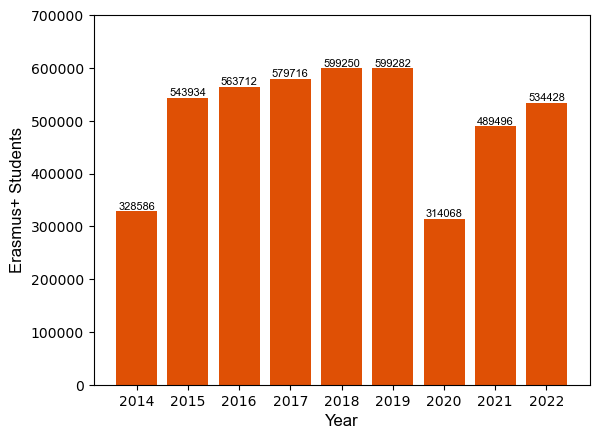

In [14]:
# Load custom font properties
custom_font = FontProperties(family='Arial', size=12)

# Create a bar chart
bars = plt.bar(YEARLY_VAI['year'], YEARLY_VAI['students'], color='#df5005')

# Add labels and title
plt.xlabel('Year', fontproperties=custom_font)
plt.ylabel('Erasmus+ Students', fontproperties=custom_font)

# Customize y ticks
plt.ylim(0, 700000)

# Add data labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{int(height)}',  # Text to display
             ha='center', va='bottom', fontsize=8, fontproperties=custom_font) 

# Ensure every year is displayed
plt.xticks(YEARLY_VAI['year']) 

# Save the plot as image
#plt.savefig('/Users/maijahavusela/Desktop/gradu/maps and graphs/number_of_students.png', bbox_inches='tight')

# Show the plot
plt.show()

### Total number per NUTS3

In [15]:
"""Aggregating all count_sum to nuts3 codes"""

# List of all yearly dataframes
dfs = [VAISANEN_2014, VAISANEN_2015, VAISANEN_2016, VAISANEN_2017, VAISANEN_2018, 
       VAISANEN_2019, VAISANEN_2020, VAISANEN_2021, VAISANEN_2022]

# Concatenate all yearly dataframes into one
VAISANEN_NUTS_ALL = pd.concat(dfs, ignore_index=True)

# Sum COUNT_SUM per NUTS3_CODE
VAISANEN_NUTS_SUMMED = VAISANEN_NUTS_ALL.groupby('NUTS3_CODE', as_index=False)['COUNT_SUM'].sum()
VAISANEN_NUTS_SUMMED

# Save data
#VAISANEN_NUTS_SUMMED.to_csv('/Users/maijahavusela/Desktop/gradu/data/pythonista/VAISANEN_nuts3_sum.csv')

,NUTS3_CODE,COUNT_SUM
0,AL012,149.0
1,AL013,11.0
2,AL015,162.0
3,AL021,282.0
4,AL022,2578.0
...,...,...
1499,UKN0C,3069.0
1500,UKN0D,39.0
1501,UKN0E,19.0
1502,UKN0F,73.0


### Graphs

In [16]:
# Define function fo aggregating student numbers to country codes
def aggregate_by_country(df, year_column, nuts3_column, count_sum_column):
    # Extract country codes from the NUTS3 column
    df['COUNTRY'] = df[nuts3_column].str[:2]
    
    # Group by COUNTRY and sum the COUNT_SUM values
    country_aggregated = df.groupby('COUNTRY')[count_sum_column].sum().reset_index()
    
    # Add the year as a new column
    country_aggregated['YEAR'] = df[year_column].iloc[0]  # Assume the year is the same for the entire DataFrame
    
    return country_aggregated

# Add country codes to VAISANEN
VAISANEN['COUNTRY'] = VAISANEN['NUTS3_CODE'].str[:2]

# Use the function
country_aggregated_14 = aggregate_by_country(VAISANEN_2014, 'YEAR', 'NUTS3_CODE', 'COUNT_SUM')
country_aggregated_15 = aggregate_by_country(VAISANEN_2015, 'YEAR', 'NUTS3_CODE', 'COUNT_SUM')
country_aggregated_16 = aggregate_by_country(VAISANEN_2016, 'YEAR', 'NUTS3_CODE', 'COUNT_SUM')
country_aggregated_17 = aggregate_by_country(VAISANEN_2017, 'YEAR', 'NUTS3_CODE', 'COUNT_SUM')
country_aggregated_18 = aggregate_by_country(VAISANEN_2018, 'YEAR', 'NUTS3_CODE', 'COUNT_SUM')
country_aggregated_19 = aggregate_by_country(VAISANEN_2019, 'YEAR', 'NUTS3_CODE', 'COUNT_SUM')
country_aggregated_20 = aggregate_by_country(VAISANEN_2020, 'YEAR', 'NUTS3_CODE', 'COUNT_SUM')
country_aggregated_21 = aggregate_by_country(VAISANEN_2021, 'YEAR', 'NUTS3_CODE', 'COUNT_SUM')
country_aggregated_22 = aggregate_by_country(VAISANEN_2022, 'YEAR', 'NUTS3_CODE', 'COUNT_SUM')
country_aggregated_22.head()

,COUNTRY,COUNT_SUM,YEAR
0,AL,702.0,2022
1,AT,12234.0,2022
2,BE,18628.0,2022
3,BG,2340.0,2022
4,CH,604.0,2022


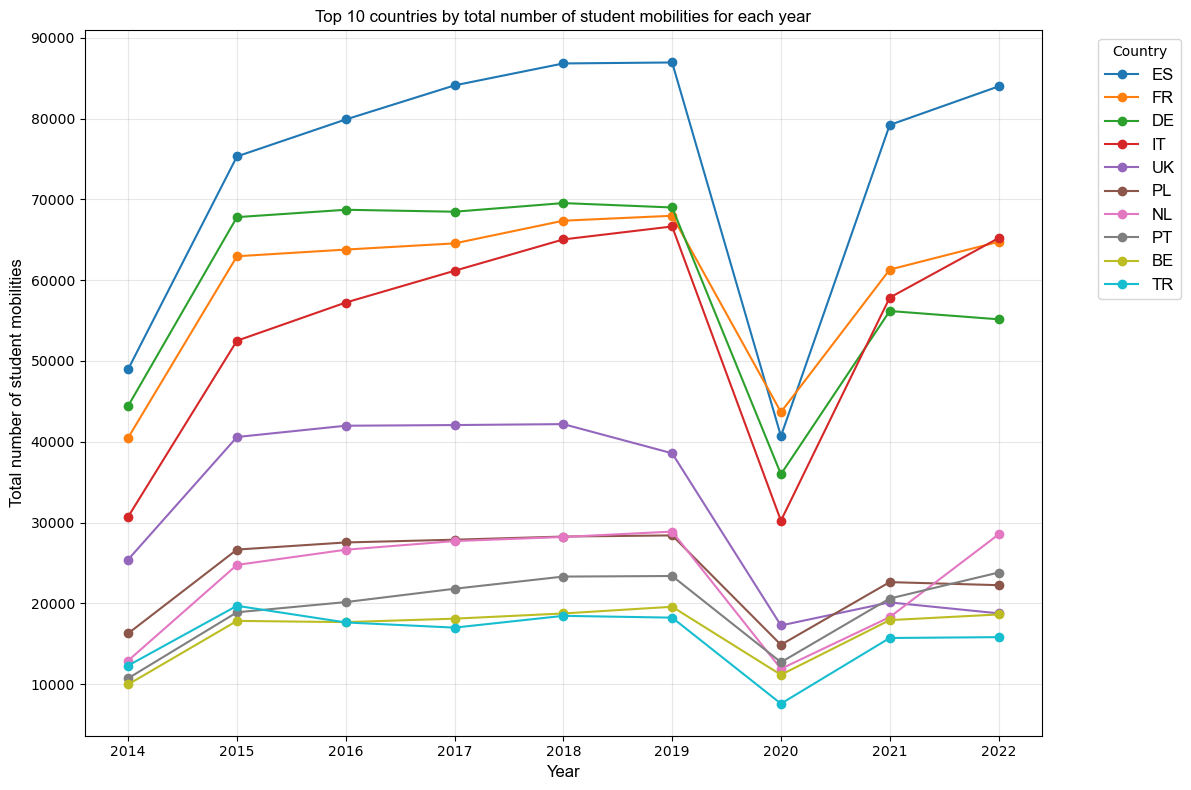

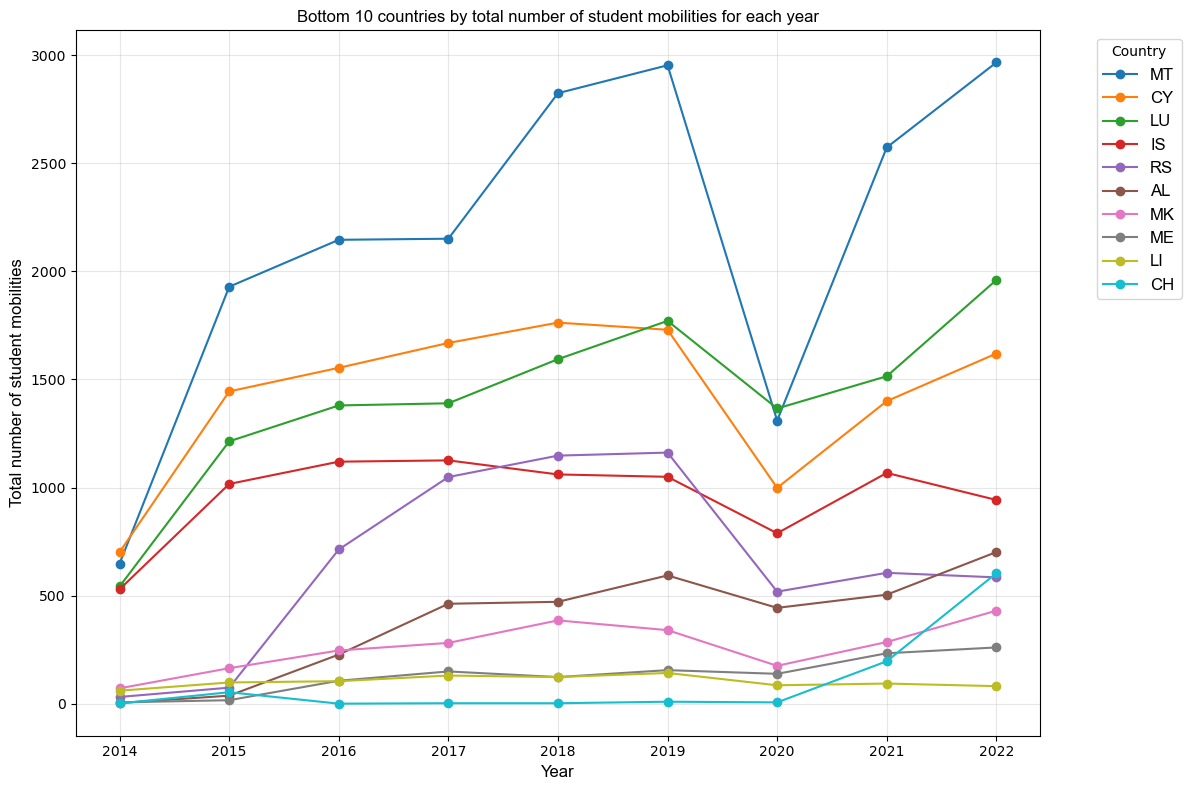

In [17]:
# Combine the aggregated data into a single DataFrame
all_years_data = pd.concat([country_aggregated_14.assign(YEAR=2014),
                            country_aggregated_15.assign(YEAR=2015),
                            country_aggregated_16.assign(YEAR=2016),
                            country_aggregated_17.assign(YEAR=2017),
                            country_aggregated_18.assign(YEAR=2018),
                            country_aggregated_19.assign(YEAR=2019),
                            country_aggregated_20.assign(YEAR=2020),
                            country_aggregated_21.assign(YEAR=2021),
                            country_aggregated_22.assign(YEAR=2022)], ignore_index=True)


# Step 1: Calculate the total COUNT_SUM for each country
total_count_sum_by_country = all_years_data.groupby('COUNTRY')['COUNT_SUM'].sum().sort_values(ascending=False)

# Step 2: Select top 10 and bottom 10 countries
top_10_countries = total_count_sum_by_country.head(10).index
bottom_10_countries = total_count_sum_by_country.tail(10).index

# Step 3: Filter the data to include only top 10 and bottom 10 countries
top_10_data = all_years_data[all_years_data['COUNTRY'].isin(top_10_countries)]
bottom_10_data = all_years_data[all_years_data['COUNTRY'].isin(bottom_10_countries)]

# Plotting the Top 10 Countries
plt.figure(figsize=(12, 8))
for country in top_10_countries:
    country_data = top_10_data[top_10_data['COUNTRY'] == country]
    plt.plot(country_data['YEAR'], country_data['COUNT_SUM'], marker='o', label=f'{country}')

plt.title('Top 10 countries by total number of student mobilities for each year',fontproperties=custom_font)
plt.xlabel('Year',fontproperties=custom_font,fontsize=12)
plt.ylabel('Total number of student mobilities',fontproperties=custom_font,fontsize=12)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left',prop=custom_font,fontsize=12)
# Adding grid with less opacity
plt.grid(True, alpha=0.3)

# Save the plot as image
#plt.savefig('/Users/maijahavusela/Desktop/gradu/maps and graphs/Top_10_countries_by_total_number.png', bbox_inches='tight')

# Show the plot for Top 10 Countries
plt.tight_layout()
plt.show()

# Plotting the Bottom 10 Countries
plt.figure(figsize=(12, 8))
for country in bottom_10_countries:
    country_data = bottom_10_data[bottom_10_data['COUNTRY'] == country]
    plt.plot(country_data['YEAR'], country_data['COUNT_SUM'], marker='o', label=f'{country}')

plt.title('Bottom 10 countries by total number of student mobilities for each year',fontproperties=custom_font,fontsize=12)
plt.xlabel('Year',fontsize=12,fontproperties=custom_font)
plt.ylabel('Total number of student mobilities',fontsize=12,fontproperties=custom_font)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left',prop=custom_font,fontsize=12)
# Adding grid with less opacity
plt.grid(True, alpha=0.3)

# Save the plot as image
#plt.savefig('/Users/maijahavusela/Desktop/gradu/maps and graphs/Bottom_10_countries_by_total_number.png', bbox_inches='tight')

# Show the plot for Bottom 10 Countries
plt.tight_layout()
plt.show()

In [18]:
# Convert it into a DataFrame
df_country = pd.DataFrame(total_count_sum_by_country)
df_country.head()

,COUNT_SUM
COUNTRY,
ES,665945.0
FR,536847.0
DE,535280.0
IT,486587.0
UK,286981.0


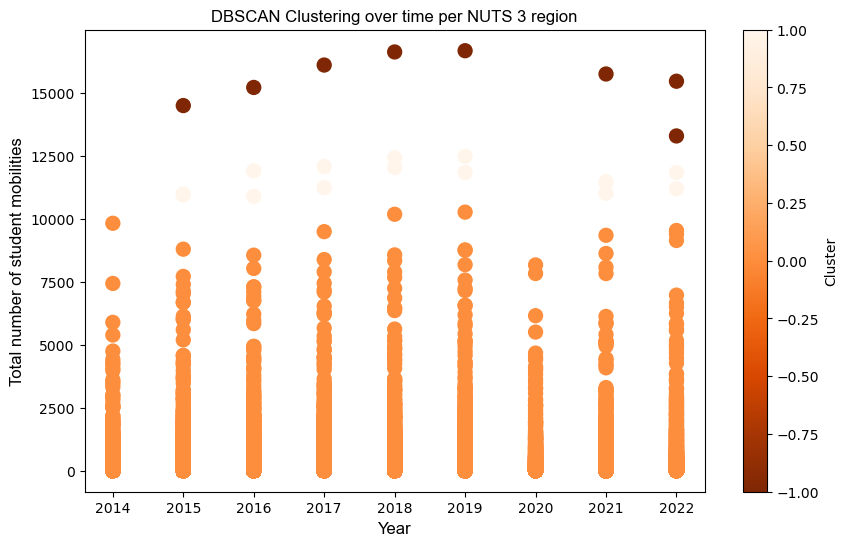

'Clustering, total number per country'

In [19]:
"""Clustering, total number per NUTS 3 region"""

# Select numerical column for clustering
X = VAISANEN[['COUNT_SUM']]

# Standardize data (DBSCAN is sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Tune eps & min_samples
VAISANEN['Cluster_nuts'] = dbscan.fit_predict(X_scaled)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(VAISANEN["YEAR"], VAISANEN["COUNT_SUM"], c=VAISANEN["Cluster_nuts"], cmap="Oranges_r", s=100)
plt.xlabel("Year", fontproperties=custom_font, fontsize=12)
plt.ylabel("Total number of student mobilities", fontproperties=custom_font, fontsize=12)
plt.title("DBSCAN Clustering over time per NUTS 3 region",fontproperties=custom_font, fontsize=12)
plt.colorbar(label="Cluster")

# Save the plot as image
#plt.savefig('/Users/maijahavusela/Desktop/gradu/maps and graphs/clustering_per_nuts3_region.png', bbox_inches='tight')

plt.show()

"""Clustering, total number per country"""

# ??

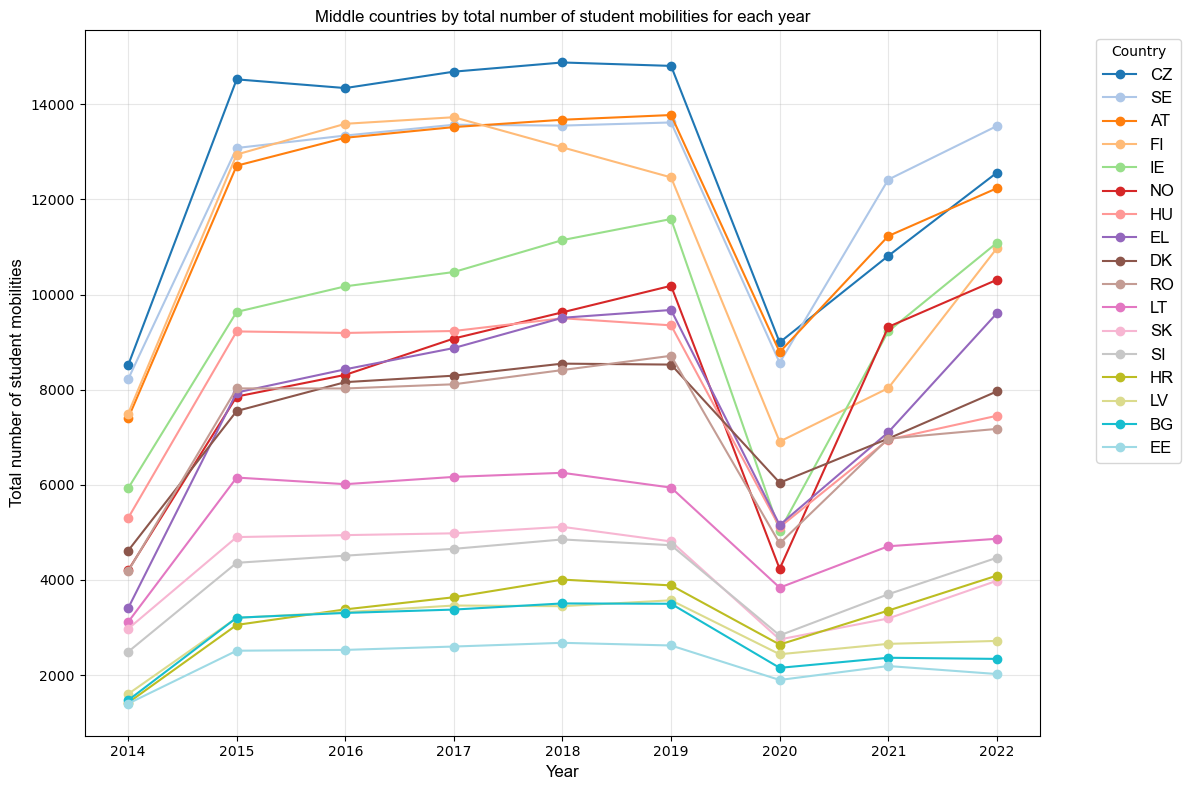

In [20]:
"""Now the middle ones"""

# Step 1: Calculate the total COUNT_SUM for each country
total_count_sum_by_country = all_years_data.groupby('COUNTRY')['COUNT_SUM'].sum().sort_values(ascending=False)

# Step 2: Select top 10 and bottom 10 countries
top_10_countries = total_count_sum_by_country.head(10).index
bottom_10_countries = total_count_sum_by_country.tail(10).index

# Step 3: Select the middle countries (countries that are neither in top 10 nor bottom 10)
middle_countries = total_count_sum_by_country.iloc[10:-10].index  # Select countries between 10 and -10

# Step 4: Filter the data to include only middle countries
middle_data = all_years_data[all_years_data['COUNTRY'].isin(middle_countries)]

# Generate a distinct color palette using matplotlib
colors = cm.tab20(np.linspace(0, 1, len(middle_countries))) 

# Plotting the Middle Countries
plt.figure(figsize=(12, 8))
# Use enumerate to iterate over the countries and assign each a color
for idx, country in enumerate(middle_countries):
    country_data = middle_data[middle_data['COUNTRY'] == country]
    plt.plot(country_data['YEAR'], country_data['COUNT_SUM'], marker='o', label=f'{country}', color=colors[idx])

# Title, labels, and legend with custom font
plt.title('Middle countries by total number of student mobilities for each year', fontproperties=custom_font)
plt.xlabel('Year', fontproperties=custom_font, fontsize=12)
plt.ylabel('Total number of student mobilities', fontproperties=custom_font, fontsize=12)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', prop=custom_font, fontsize=12)

# Adding grid with less opacity
plt.grid(True, alpha=0.3)  # 0.3 makes the grid slightly transparent

# Save the plot as image (optional)
#plt.savefig('/Users/maijahavusela/Desktop/gradu/maps and graphs/Middle_countries_by_total_number.png', bbox_inches='tight')

# Show the plot for Middle Countries
plt.tight_layout()
plt.show()

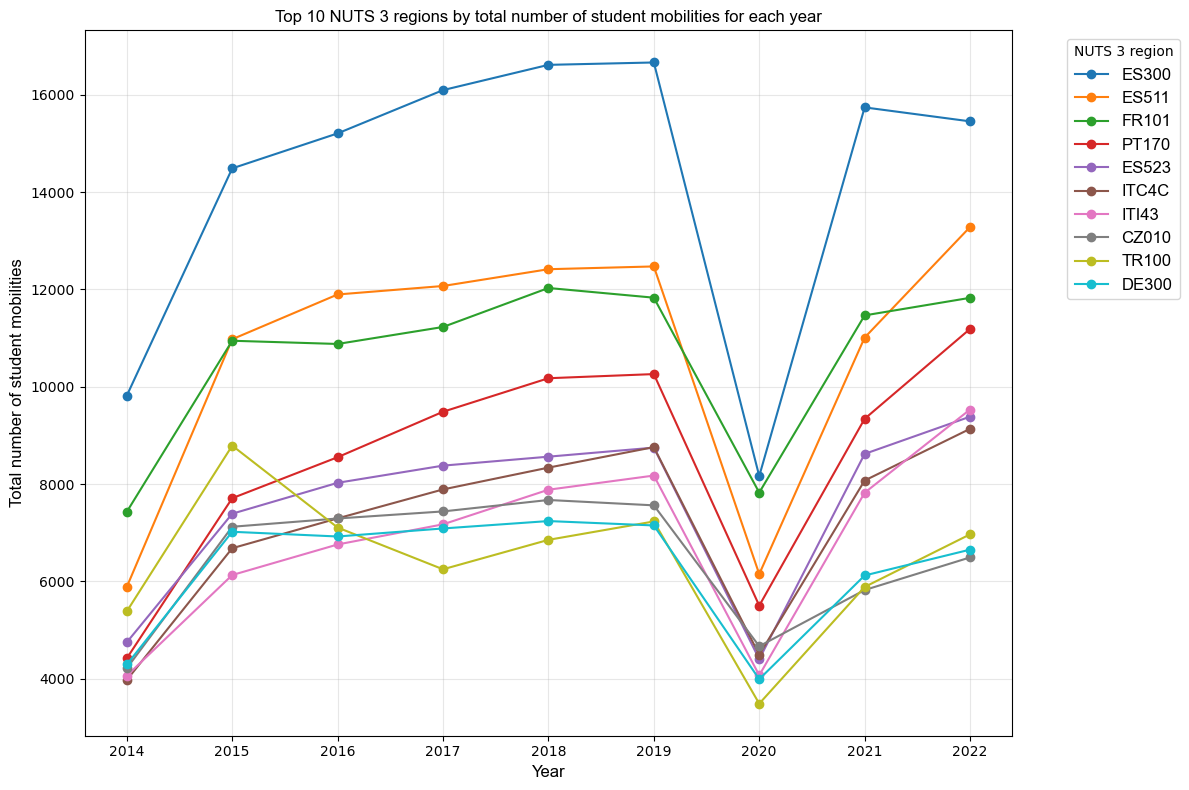

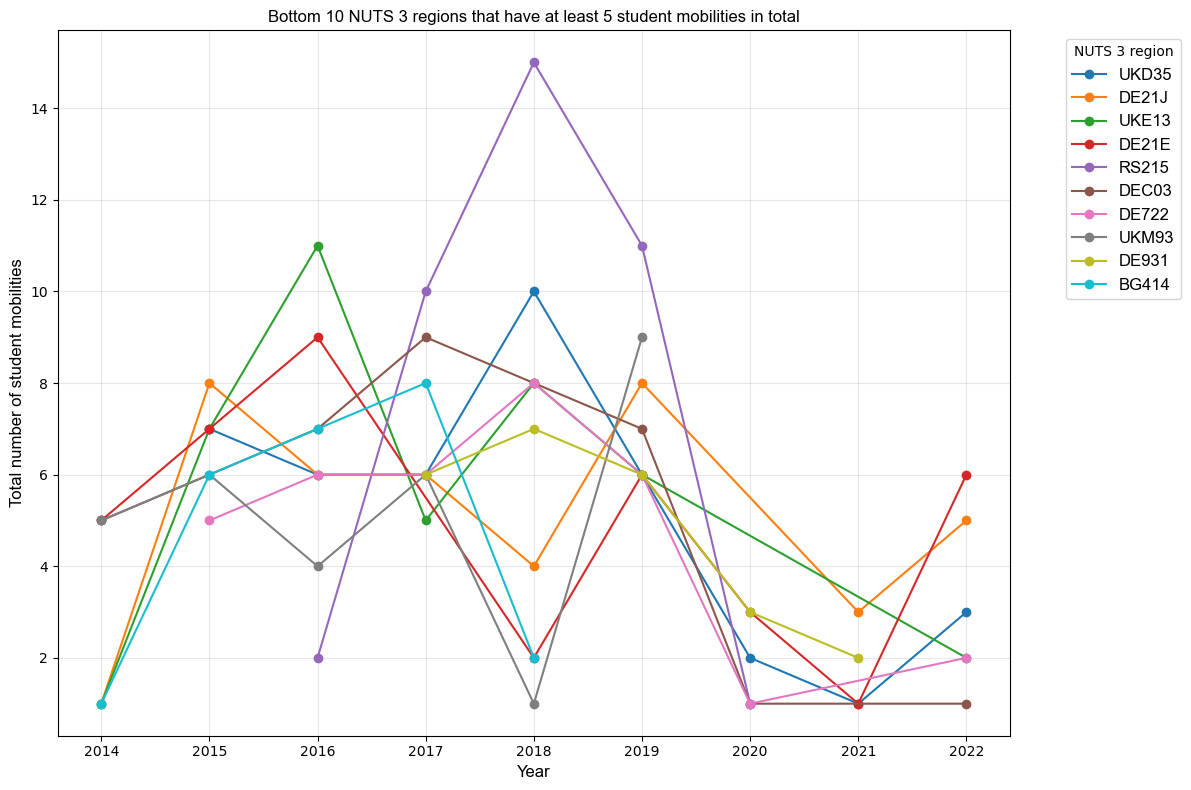

In [21]:
"""Per NUTS 3 region"""

# Step 1: Calculate the total COUNT_SUM for each region
total_count_sum_by_region = filtered_df.groupby('NUTS3_CODE')['COUNT_SUM'].sum().sort_values(ascending=False)

# Step 2: Select top 10 and bottom 10 regions
top_10_regions = total_count_sum_by_region.head(10).index
bottom_10_regions = total_count_sum_by_region.tail(10).index

# Step 3: Filter the data to include only top 10 and bottom 10 regions
top_10_data_region = filtered_df[filtered_df['NUTS3_CODE'].isin(top_10_regions)]
bottom_10_data_region = filtered_df[filtered_df['NUTS3_CODE'].isin(bottom_10_regions)]

# Plotting the Top 10 regions
plt.figure(figsize=(12, 8))
for region in top_10_regions:
    region_data = top_10_data_region[top_10_data_region['NUTS3_CODE'] == region]
    plt.plot(region_data['YEAR'], region_data['COUNT_SUM'], marker='o', label=f'{region}')

plt.title('Top 10 NUTS 3 regions by total number of student mobilities for each year',fontproperties=custom_font)
plt.xlabel('Year',fontproperties=custom_font,fontsize=12)
plt.ylabel('Total number of student mobilities',fontproperties=custom_font,fontsize=12)
plt.legend(title='NUTS 3 region', bbox_to_anchor=(1.05, 1), loc='upper left',prop=custom_font,fontsize=12)
# Adding grid with less opacity
plt.grid(True, alpha=0.3)

# Save the plot as image
#plt.savefig('/Users/maijahavusela/Desktop/gradu/maps and graphs/Top_10_regions_by_total_number.png', bbox_inches='tight')

# Show the plot for Top 10 regions
plt.tight_layout()
plt.show()

# Plotting the Bottom 10 regions
plt.figure(figsize=(12, 8))
for region in bottom_10_regions:
    region_data = bottom_10_data_region[bottom_10_data_region['NUTS3_CODE'] == region]
    plt.plot(region_data['YEAR'], region_data['COUNT_SUM'], marker='o', label=f'{region}')

plt.title('Bottom 10 NUTS 3 regions that have at least 5 student mobilities in total',fontproperties=custom_font,fontsize=12)
plt.xlabel('Year',fontsize=12,fontproperties=custom_font)
plt.ylabel('Total number of student mobilities',fontsize=12,fontproperties=custom_font)
plt.legend(title='NUTS 3 region', bbox_to_anchor=(1.05, 1), loc='upper left',prop=custom_font,fontsize=12)
# Adding grid with less opacity
plt.grid(True, alpha=0.3)

# Save the plot as image
#plt.savefig('/Users/maijahavusela/Desktop/gradu/maps and graphs/Bottom_10_regions_by_total_number_5_2.png', bbox_inches='tight')

# Show the plot for Bottom 10 regions
plt.tight_layout()
plt.show()

In [27]:
"""Suhteellinen muutos ekaan vuoteen, 2014, verrattuna"""

# Eli prosentuaalinen muutos vuodesta 2014 vuoteen 2015, 2016 jne. (pitäs olla simppeli XD)

'Suhteellinen muutos ekaan vuoteen, 2014, verrattuna'

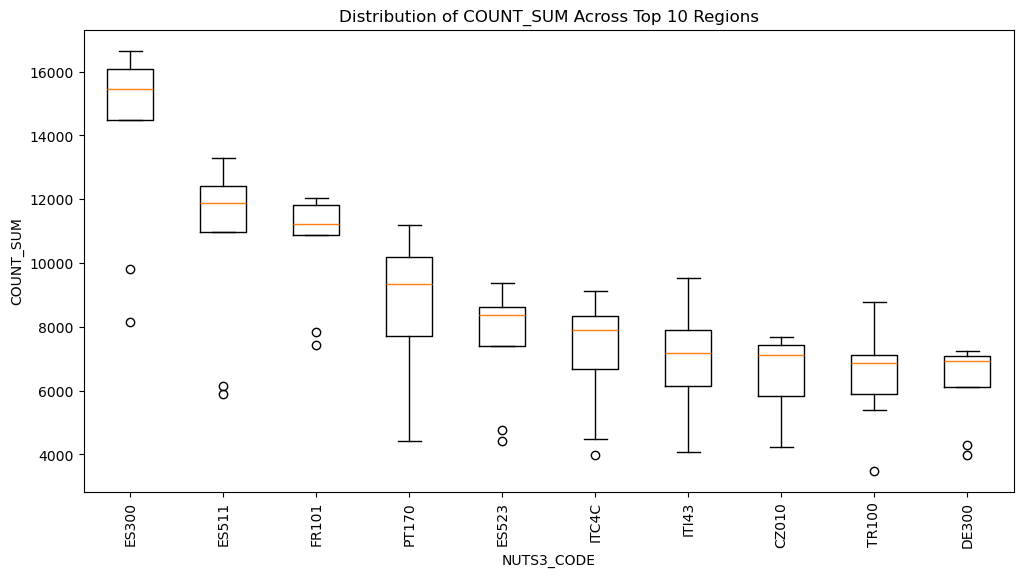

In [22]:
"""Joku random box plot"""

# Calculate the total COUNT_SUM per NUTS3_CODE
region_totals = VAISANEN.groupby('NUTS3_CODE')['COUNT_SUM'].sum().sort_values(ascending=False)

# Select the top N regions (e.g., top 10)
top_n = 10
top_n_regions = region_totals.head(top_n).index

# Prepare data for the boxplot: group the data by the top N regions
grouped_data = [VAISANEN[VAISANEN['NUTS3_CODE'] == nuts]['COUNT_SUM'].values for nuts in top_n_regions]

# Create the boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(grouped_data, labels=top_n_regions, vert=True)

# Set titles and labels
plt.title(f'Distribution of COUNT_SUM Across Top {top_n} Regions')
plt.xlabel('NUTS3_CODE')
plt.ylabel('COUNT_SUM')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()

### ANOVA test

In [23]:
"""ANOVA, country"""

# Group by YEAR and COUNTRY, then collect the COUNT_SUM values for each year and country combination
grouped_anova_vai = VAISANEN.groupby(['YEAR', 'COUNTRY'])['COUNT_SUM'].apply(list).reset_index()

# Extract the groups for ANOVA
# Group the data by 'YEAR' and collect 'COUNT_SUM' for each YEAR
groups = [grouped_anova_vai[grouped_anova_vai['YEAR'] == year]['COUNT_SUM'].values[0] for year in grouped_anova_vai['YEAR'].unique()]

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*groups)

# Output the results
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

# Check if the result is statistically significant
if p_value < 0.05:
    print("There is a statistically significant difference between the groups.")
else:
    print("There is no statistically significant difference between the groups.")

F-statistic: 0.3998829698807443
P-value: 0.9154700013624844
There is no statistically significant difference between the groups.


In [24]:
"""ANOVA, region"""

# Group by NUTS3_CODE and collect all COUNT_SUM values for each region
grouped_anova_vai_nuts = VAISANEN.groupby('NUTS3_CODE')['COUNT_SUM'].apply(list).reset_index()

# Extract the groups for ANOVA (collect all COUNT_SUM values for each region)
groups_nuts = [grouped_anova_vai_nuts[grouped_anova_vai_nuts['NUTS3_CODE'] == nuts]['COUNT_SUM'].values[0] 
               for nuts in grouped_anova_vai_nuts['NUTS3_CODE'].unique()]

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*groups_nuts)

# Output the results
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

# Check if the result is statistically significant
if p_value < 0.05:
    print("There is a statistically significant difference between the regions.")
else:
    print("There is no statistically significant difference between the regions.")

F-statistic: 127.55411434677755
P-value: 0.0
There is a statistically significant difference between the regions.


In [25]:
VAISANEN.head()

,NUTS3_CODE,YEAR,ORIGIN_COUNT,DESTINATION_COUNT,COUNT_SUM,COUNTRY,Cluster_nuts
0,AL012,2016,1.0,NaN,1.0,AL,0
1,AL012,2017,2.0,NaN,2.0,AL,0
2,AL012,2018,6.0,NaN,6.0,AL,0
3,AL012,2019,3.0,NaN,3.0,AL,0
4,AL012,2020,14.0,2.0,16.0,AL,0
